# **GiST?**

**Generalized Search Tree**

 - 임의의 인덱싱 스키마를 구현하는 기본 template 역할을 하는
 - B-trees, R-trees 및 여러 인덱싱 스키마는 GiST를 통해 구현할 수 있음
 - GiST의 장점 중 하나는 DB 전문가가 아닌 data 유형 영역의 전문가가 적절한 엑세스 방법으로 사용자 정의 데이터 유형을 개발할 수 있음


**내장된 연산자 클래스**


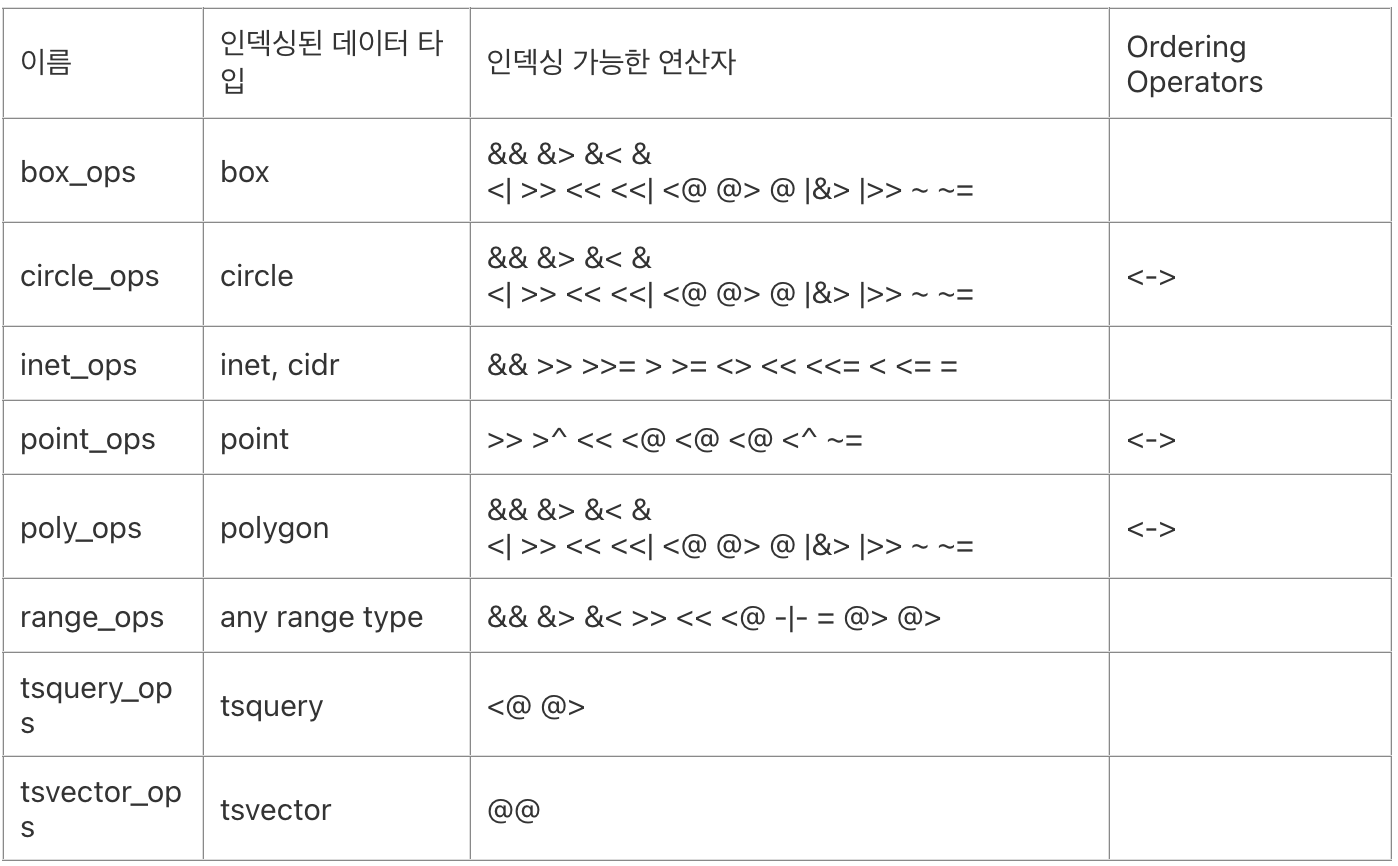

- 역사적인 이유로 인해, inet_opt 연산자는 inet 및 cidr 유형의 기본 클래스가 아님.
- 이를 사용하려면 CREATE INDEX에서 언급해야 함(CREATE INDEX ON my_table USING GIST(my_inet_column inet_ops;))

**확장성**

- 전통적으로 새로운 인덱스 엑세스 메소드를 구현하는 건 쉽지 않은 일이었음.
  - 잠금 관리자 및 미리 쓰기 로그 등의 db 내부 동작을 이해하는 게 필요했음.
  - GiST 인터페이스는 높은 레벨의 추상화를 지니고 있어 access method를 구현하는 사람이 access되는 data type의 의미를 구현하기만 하면 됨.
  - GiST 계층 자체는 트리구조의 동시성, 로깅 및 검색을 지원

- 이 확장성은 처리할 수 있는 데이터의 측면에서 다른 표준 탐색 트리의 확장성과 혼동되어선 안 됨(PostgreSQL은 확장성 있는 B-tree와 해시 인덱스를 지원하는데, 그건 사용자가 PostgreSQL을 사용하여 원하는 모든 데이터 유형에 대해 B-tree나 해시를 구축할 수 있지만 B-Tree는 <, =, >만 지원하고 해시 인덱스는 equality 쿼리만 지원)

- PostgreSQL B-tree로 이미지 컬렉션을 할 경우, 'is imagex equal to imagey', 'is imagex less than imagey', 'imagex greater than imagy' 와 같은 쿼리만 실행할 수 있음.
  - 이 컨텍스트에서 'equals', 'less than', 'greater than' 를 어떻게 정의하느냐에 따라 이 기법이 유용할 수 있음. 그러나 GiST에 기반한 인덱스를 사용하여 도메인 별 질문을 하는 방법을 만들어낼 수 있고, '말의 모든 이미지 찾기' 나 '과다 노출되는 모든 이미지 찾기' 등을 사용할 수 있음

- GiST 액세스 방법을 시작하고 실행하는 데 필요한 모든 것은 트리에서 키의 동작을 정의하는 여러 사용자 정의 방법을 구현하는 것.
  - 이러한 메서드는 양질의 쿼리를 지원하기 위해 꽤 화려해야 하지만 모든 표준 쿼리(B-트리, R-트리 등)에 대해 비교적 간단.
  - GiST는 확장성과 일반성, 코드 재사용 및 깨끗한 인터페이스를 결합

- GiST가 제공하는 7가지 인덱스 연산자 클래스가 있고, 선택적인 두 가지 방법이 존재.
  - 인덱스의 정확성은 same, consistent, union 메소드의 적절한 구현에 의해 보장되지만, 효율성(크기, 속도)는 패널티와 picksplit 메소드에 의해 달라짐.
  - 나머지 두 기법은 compress와 decompress로, 인덱스가 인덱싱하는 데이터 및 다른 유형의 내부 tree data를 가질 수 있도록 함.

- 동일하고 일관성 있는 통합 방법의 적절한 구현에 의해 보장되는 반면 인덱스의 효율성(크기 및 속도)은 패널티 및 fix flit 방법에 따라 달라짐.
  - 나머지 두 가지 기본 방법은 인덱스가 인덱싱하는 데이터와 다른 유형의 내부 트리 데이터를 가질 수 있도록 하는 압축 및 압축 해제 기법.
  - leaves는 인덱싱된 데이터 유형이어야 하고 다른 트리 노드는 모든 C 구조체가 될 수 있음.(단, PostgreSQL 데이터 유형 규칙을 준수해야 함).
  - 트리의 내부 데이터 유형이 SQL 레벨에 존재하는 경우 CREATE OPERATOR CLASS 명령의 STORAGE 옵션을 사용할 수 있음.
  - 선택적인 여덟 번째 방법은 distance이며, 이는 운영자 클래스가 정렬된 스캔(가장 가까운 이웃 검색)을 지원하려는 경우에 필요.
  - 선택적 9번째 방법인 method 가져오기는 연산자 클래스가 인덱스 전용 스캔을 지원하려는 경우에 필요

1. consistent
 - 인덱스 항목 p와 쿼리값 q가 주어졌을 때, 인덱스 엔트리가 '일관되었는지' 여부를 판단.
 - 'indexed_column indexable_operator q' 술어가 인덱스 항목이 나타내는 모든 항목에 대해 참일 수 있는지 판별하자면, 리프 인덱스 항목의 경우 이는 인덱싱 가능한 조건을 테스트하는 것과 동일하지만 내부 트리 노드의 경우 트리 노드가 나타내는 인덱스의 하위 트리를 스캔해야 하는지 여부를 결정.
 -  결과가 참일 경우, recheck 플래그도 마찬가지로 반환되어야 함.
 - 이 지시자는 술어가 확실히 true인지, 아니면 true의 가능성이 있는지를 나타냄.
 - 만일 recheck = false 인 경우 제시된 조건을 정확하게 테스트한 반면, recheck가 true일 경우 그 row는 일치 가능성이 있는 후보일 뿐임.
 - 이 경우 시스템은 실제 행 값에 대해 indexable_operator를 자동으로 평가하여 실제로 일치하는지 확인.
 - 이 규칙을 통해 GiST는 무손실 및 손실 인덱스 구조를 모두 지원할 수 있음

**함수의 SQL 정의**

```sql
CREATE OR REPLACE FUNCTION my_consistent(internal, data_type, smallint, oid, internal)
RETURNS bool
AS 'MODULE_PATHNAME'
LANGUAGE C STRICT;

-- C 모듈과 일치하는 코드는 다음과 같은 skeleton을 따를 수 있음

PG_FUNCTION_INFO_V1(my_consistent);

Datum
my_consistent(PG_FUNCTION_ARGS)
{
    GISTENTRY  *entry = (GISTENTRY *) PG_GETARG_POINTER(0);
    data_type  *query = PG_GETARG_DATA_TYPE_P(1);
    StrategyNumber strategy = (StrategyNumber) PG_GETARG_UINT16(2);
    /* Oid subtype = PG_GETARG_OID(3); */
    bool       *recheck = (bool *) PG_GETARG_POINTER(4);
    data_type  *key = DatumGetDataType(entry->key);
    bool        retval;

    /*
     * determine return value as a function of strategy, key and query.
     *
     * Use GIST_LEAF(entry) to know where you're called in the index tree,
     * which comes handy when supporting the = operator for example (you could
     * check for non empty union() in non-leaf nodes and equality in leaf
     * nodes).
     */

    *recheck = true;        /* or false if check is exact */

    PG_RETURN_BOOL(retval);
}
```

- 여기에서 key는 인덱스의 속성이고 인덱스에서 조회되는 값을 쿼리.
- StrategyNumber 파라메터는 적용 중인 연산자 클래스의 연산자를 나타냄 - CREATE OPERATOR CLASS 커맨드의 연산자 번호 중 하나와 일치.
- 클래스에 포함시킨 연산자에 따라 쿼리의 데이터 유형이 연산자에 따라 다를 수 있지만 위의 skeleton에서는 그렇지 않다고 가정

2. union
 - 이 메소드는 정보를 트리에서 참조.
 - 엔트리 집합이 주어지면, 이 함수는 주어진 모든 항목을 나타내는 새 인덱스 항목을 생성

 **함수의 SQL 정의**

```sql
CREATE OR REPLACE FUNCTION my_union(internal, internal)
RETURNS internal
AS 'MODULE_PATHNAME'
LANGUAGE C STRICT;

-- C 모듈과 일치하는 코드는 다음과 같은 skeleton을 따를 수 있음

PG_FUNCTION_INFO_V1(my_union);

Datum
my_union(PG_FUNCTION_ARGS)
{
    GistEntryVector *entryvec = (GistEntryVector *) PG_GETARG_POINTER(0);
    GISTENTRY  *ent = entryvec->vector;
    data_type  *out,
               *tmp,
               *old;
    int         numranges,
                i = 0;

    numranges = entryvec->n;
    tmp = DatumGetDataType(ent[0].key);
    out = tmp;

    if (numranges == 1)
    {
        out = data_type_deep_copy(tmp);

        PG_RETURN_DATA_TYPE_P(out);
    }

    for (i = 1; i < numranges; i++)
    {
        old = out;
        tmp = DatumGetDataType(ent[i].key);
        out = my_union_implementation(out, tmp);
    }

    PG_RETURN_DATA_TYPE_P(out);
}
```

- 위 코드에서 보이듯, union(X,Y,Z) = union(union(X,Y),Z) 의 형태를 지닌 skeleton을 볼 수 있음(old, tmp, out).
- 이 GiST 지원 방법에서 적절한 합집합 알고리즘을 구현하여 그렇지 않은 데이터 유형을 충분히 지원함을 알 수 있음
- union implemantation method는 새로 palloc()된 메모리에 대한 포인터를 반환해야 함. 입력된 값이 무엇이든 그 상태 그대로 반환할 수는 없음

3. compress
 - data item을 인덱스 페이지의 물리적 저장소에 적합한 형태로 변환

 **함수의 SQL 정의**

```sql
CREATE OR REPLACE FUNCTION my_compress(internal)
RETURNS internal
AS 'MODULE_PATHNAME'
LANGUAGE C STRICT;

-- C 모듈과 일치하는 코드는 다음과 같은 skeleton을 따를 수 있음

PG_FUNCTION_INFO_V1(my_compress);

Datum
my_compress(PG_FUNCTION_ARGS)
{
    GISTENTRY  *entry = (GISTENTRY *) PG_GETARG_POINTER(0);
    GISTENTRY  *retval;

    if (entry->leafkey)
    {
        /* replace entry->key with a compressed version */
        compressed_data_type *compressed_data = palloc(sizeof(compressed_data_type));

        /* fill *compressed_data from entry->key ... */

        retval = palloc(sizeof(GISTENTRY));
        gistentryinit(*retval, PointerGetDatum(compressed_data),
                      entry->rel, entry->page, entry->offset, FALSE);
    }
    else
    {
        /* typically we needn't do anything with non-leaf entries */
        retval = entry;
    }

    PG_RETURN_POINTER(retval);
}
```

- compressed_data_type을 통해 leaf node를 압축하기 위해 변환하려는 특정 유형에 적용할 수 있음

4. decompress
 - compress의 반대 개념.
 - 데이터 아이템의 인덱스 형태를 연산자 클래스의 다른 GiST 메소드가 변환할 수 있는 형태로 변환

 **함수의 SQL 정의**

```sql
CREATE OR REPLACE FUNCTION my_decompress(internal)
RETURNS internal
AS 'MODULE_PATHNAME'
LANGUAGE C STRICT;

-- C 모듈과 일치하는 코드는 다음과 같은 skeleton을 따를 수 있음

PG_FUNCTION_INFO_V1(my_decompress);

Datum
my_decompress(PG_FUNCTION_ARGS)
{
    PG_RETURN_POINTER(PG_GETARG_POINTER(0));
}
```

- 상기의 skeleton은 압축 해제할 필요가 없을 경우에 적합

5. penalty
 - tree의 특정 branch에 새 entry를 insert하는 "cost" 를 나타내는 값을 반환.
 - 항목은 트리에서 페널티가 가장 적은 경로에 삽입됨.
 - 페널티에 의해 반환된 값은 음수가 아니어야 하고, 음수 값 반환 시 0으로 처리됨

 **함수의 SQL 정의**

```sql
CREATE OR REPLACE FUNCTION my_penalty(internal, internal, internal)
RETURNS internal
AS 'MODULE_PATHNAME'
LANGUAGE C STRICT;  -- in some cases penalty functions need not be strict

-- C 모듈과 일치하는 코드는 다음과 같은 skeleton을 따를 수 있음

PG_FUNCTION_INFO_V1(my_penalty);

Datum
my_penalty(PG_FUNCTION_ARGS)
{
    GISTENTRY  *origentry = (GISTENTRY *) PG_GETARG_POINTER(0);
    GISTENTRY  *newentry = (GISTENTRY *) PG_GETARG_POINTER(1);
    float      *penalty = (float *) PG_GETARG_POINTER(2);
    data_type  *orig = DatumGetDataType(origentry->key);
    data_type  *new = DatumGetDataType(newentry->key);

    *penalty = my_penalty_implementation(orig, new);
    PG_RETURN_POINTER(penalty);
}
```

- penalty 함수는 index의 성능 향상에 유용.
- tree에서 새 entry를 추가할 branch를 결정하기 위해 insert 할 경우 사용.
- 쿼리 시 index 간의 균형도이 맞을수록 더 빨리 조회

6. picksplit
 - index page 분할이 필요할 때, 이 함수는 페이지의 특정 항목을 이전 페이지에 유지할지, 새 페이지에 이동시킬지 결정.

 **함수의 SQL 정의**

```sql
CREATE OR REPLACE FUNCTION my_picksplit(internal, internal)
RETURNS internal
AS 'MODULE_PATHNAME'
LANGUAGE C STRICT;

-- C 모듈과 일치하는 코드는 다음과 같은 skeleton을 따를 수 있음

PG_FUNCTION_INFO_V1(my_picksplit);

Datum
my_picksplit(PG_FUNCTION_ARGS)
{
    GistEntryVector *entryvec = (GistEntryVector *) PG_GETARG_POINTER(0);
    OffsetNumber maxoff = entryvec->n - 1;
    GISTENTRY  *ent = entryvec->vector;
    GIST_SPLITVEC *v = (GIST_SPLITVEC *) PG_GETARG_POINTER(1);
    int         i,
                nbytes;
    OffsetNumber *left,
               *right;
    data_type  *tmp_union;
    data_type  *unionL;
    data_type  *unionR;
    GISTENTRY **raw_entryvec;

    maxoff = entryvec->n - 1;
    nbytes = (maxoff + 1) * sizeof(OffsetNumber);

    v->spl_left = (OffsetNumber *) palloc(nbytes);
    left = v->spl_left;
    v->spl_nleft = 0;

    v->spl_right = (OffsetNumber *) palloc(nbytes);
    right = v->spl_right;
    v->spl_nright = 0;

    unionL = NULL;
    unionR = NULL;

    /* Initialize the raw entry vector. */
    raw_entryvec = (GISTENTRY **) malloc(entryvec->n * sizeof(void *));
    for (i = FirstOffsetNumber; i <= maxoff; i = OffsetNumberNext(i))
        raw_entryvec[i] = &(entryvec->vector[i]);

    for (i = FirstOffsetNumber; i <= maxoff; i = OffsetNumberNext(i))
    {
        int         real_index = raw_entryvec[i] - entryvec->vector;

        tmp_union = DatumGetDataType(entryvec->vector[real_index].key);
        Assert(tmp_union != NULL);

        /*
         * Choose where to put the index entries and update unionL and unionR
         * accordingly. Append the entries to either v->spl_left or
         * v->spl_right, and care about the counters.
         */

        if (my_choice_is_left(unionL, curl, unionR, curr))
        {
            if (unionL == NULL)
                unionL = tmp_union;
            else
                unionL = my_union_implementation(unionL, tmp_union);

            *left = real_index;
            ++left;
            ++(v->spl_nleft);
        }
        else
        {
            /*
             * Same on the right
             */
        }
    }

    v->spl_ldatum = DataTypeGetDatum(unionL);
    v->spl_rdatum = DataTypeGetDatum(unionR);
    PG_RETURN_POINTER(v);
}
```

- penalty와 유사하게 picksplit 함수 또한 인덱스 성능 향상에 유연.
- 적절한 penalty 및 picksplit 구현을 설계하는 것은 우수한 GiST 지수를 구현하는 데에 있어 어려운 숙제

7. same
 - 두 index 항목이 식별 가능하다면 true를, 그렇지 않다면 false를 반환.

 **함수의 SQL 정의**

```sql
CREATE OR REPLACE FUNCTION my_same(internal, internal, internal)
RETURNS internal
AS 'MODULE_PATHNAME'
LANGUAGE C STRICT;

-- C 모듈과 일치하는 코드는 다음과 같은 skeleton을 따를 수 있음

PG_FUNCTION_INFO_V1(my_same);

Datum
my_same(PG_FUNCTION_ARGS)
{
    prefix_range *v1 = PG_GETARG_PREFIX_RANGE_P(0);
    prefix_range *v2 = PG_GETARG_PREFIX_RANGE_P(1);
    bool       *result = (bool *) PG_GETARG_POINTER(2);

    *result = my_eq(v1, v2);
    PG_RETURN_POINTER(result);
}
```

- 고전적인 이유로, same 함수는 Boolean만 리턴하지 않음.
- 대신 세 번째 인수에 의해 지정된 위치에 flag를 저장해야 함

8. distance
 - p라는 index entry와 q라는 쿼리 값이 있을 때, 이 함수는 쿼리값으로부터 index entry의 '거리' 를 측정.
 - 연산자 클래스에 순서 연산자가 포함된 경우 이 함수를 제공해야 함.
 - 순서 연산자를 사용하는 쿼리는 가장 작은 '거리' 값을 가진 index entry를 먼저 반환함으로써 구현되므로 결과는 연산자의 의미와 일치해야 함.
 - leaf index entry의 경우 결과는 index entry까지의 거리만 나타내며, 내부 트리 노드의 경우 결과는 하위 항목이 가질 수 있는 최소 거리여야 함.

 **함수의 SQL 정의**

```sql
CREATE OR REPLACE FUNCTION my_distance(internal, data_type, smallint, oid)
RETURNS float8
AS 'MODULE_PATHNAME'
LANGUAGE C STRICT;

-- C 모듈과 일치하는 코드는 다음과 같은 skeleton을 따를 수 있음

PG_FUNCTION_INFO_V1(my_distance);

Datum
my_distance(PG_FUNCTION_ARGS)
{
    GISTENTRY  *entry = (GISTENTRY *) PG_GETARG_POINTER(0);
    data_type  *query = PG_GETARG_DATA_TYPE_P(1);
    StrategyNumber strategy = (StrategyNumber) PG_GETARG_UINT16(2);
    /* Oid subtype = PG_GETARG_OID(3); */
    /* bool *recheck = (bool *) PG_GETARG_POINTER(4); */
    data_type  *key = DatumGetDataType(entry->key);
    double      retval;

    /*
     * determine return value as a function of strategy, key and query.
     */

    PG_RETURN_FLOAT8(retval);
}
```

- distance 함수의 인자는 일관된 함수의 인자와 동일해야 함.
- 결과를 입력한 것의 실제 거리보다 크게 만들지 않는 한, dintance를 결정할 때 약간의 근사치가 허용됨(bounding box까지의 거리는 일반적으로 기하학적 애플리케이션에서 충분함.)
- 내부 트리 노드는 반환되는 거리가 하위 노드까지의 거리보다 커서는 안 됨.
- 반환된 거리가 정확하지 않으면 함수는 *recheck를 true로 설정(이건 내부 트리 노드의 경우 필요치 않고, 계산은 항상 부정확한 것으로 가정).
- 이 경우 실행자는 heap에서 tuple을 가져온 후 정확한 거리를 계산하고 필요한 경우 tuple 순서를 다시 정함


9. fetch
  - 인덱스 전용 검사를 위해 데이터 항목의 압축된 인덱스 표현을 원래 데이터 유형으로 변환.
  - 반환된 데이터는 원래 인덱스 값에서 손실이 없는 정확한 복사본이어야 함

 **함수의 SQL 정의**

```sql
CREATE OR REPLACE FUNCTION my_fetch(internal)
RETURNS internal
AS 'MODULE_PATHNAME'
LANGUAGE C STRICT;

-- C 모듈과 일치하는 코드는 다음과 같은 skeleton을 따를 수 있음

PG_FUNCTION_INFO_V1(my_fetch);

Datum
my_fetch(PG_FUNCTION_ARGS)
{
    GISTENTRY  *entry = (GISTENTRY *) PG_GETARG_POINTER(0);
    input_data_type *in = DatumGetPointer(entry->key);
    fetched_data_type *fetched_data;
    GISTENTRY  *retval;

    retval = palloc(sizeof(GISTENTRY));
    fetched_data = palloc(sizeof(fetched_data_type));

    /*
     * Convert 'fetched_data' into the a Datum of the original datatype.
     */

    /* fill *retval from fetched_data. */
    gistentryinit(*retval, PointerGetDatum(converted_datum),
                  entry->rel, entry->page, entry->offset, FALSE);

    PG_RETURN_POINTER(retval);
}
```

- 압축된 method가 leaf entriy에 대해 느슨할 경우, 연산자 클래스는 index-only 스캔을 지원할 수 없으며, 'fetch' 함수를 정의해서는 안 됨
- GiST에서 지원하는 모든 method는 짧은 생명 주기를 지는 메모리 콘텍스트에서 호출.
  - 즉, CurrentMenoryContext는 각각의 tuple이 처리된 후 재설치.
  - 그러므로 palloc에 대해 너무 걱정하지 않아도 됨.
- 그러나 경우에 따라 반복되는 호출에서 data를 캐싱하는 것이 유용.
  - 이를 위해 fcinfo->flinfo->fn_mcxt에 더 긴 수명 data를 할당하고, fcinfo->fn_extra에 포인터를 유지해야 함.
  - 이러한 데이터들은 index 작업의 수명(ex. 단일 GiST의 인덱스 스캔, 인덱스 빌드, 인덱스 튜플 insert)동안 생존.
- fn_extra값을 교체할 경우 이전 값을 pfree로 하지 않을 경우 동작 시간 동안 data의 누수가 누적.


**GiST 버퍼링 빌드**



- index tuple이 index 전체에 흩어져 있고, index가 cache에 맞지 않을 정도로 크면 insert 과정에서 수많은 랜덤성 I/O를 수행해야 하기 때문에, 모든 tuple을 단순 삽입을 통해 큰 사이즈의 GiST index를 구성하는 건 느린 경향이 있음.

- PostgreSQL 9.2부터 버퍼링을 기반으로 한 GiST index를 구축하는 보다 효율적인 방법을 지원하기 대문에, 미정렬 된 data set에 필요한 임의 I/O의 수를 크게 줄일 수 있음.

- 잘 정렬된 데이터 세트는 한 번에 적은 수의 페이지만 새 tuple을 수신하고 해당 페이지는 전체 index가 그렇지 않은 경우에도 cache에 맞기 때문에 취할 수 있는 이득이 적음, 그러나 buffering index build는 패널티 함수의 호출 빈도가 높으므로 일부 추가 CPU 리소스를 소모.

- buffering build에 사용되는 buffer에는 결과 index에 대한 임시 디스크 공간이 필요.
- 결과 index의 질에 양수 및 음수 방향 모두에 영향을 줄 수 있는데, 그 영향은 입력 데이터의 분포 및 연산자 클래스 구현과 같은 다양한 요인에 따라 다름.
- 기본적으로 GiST 인덱스 빌드는 인덱스 크기가 effective_cache_size에 도달하면 buffering 방식으로 전환(CREATE INDEX 명령에 대한 buffering 매개변수로 수동으로 켜거나 끌 수 있음).
- 대부분의 경우 기본 동작은 좋지만 buffering을 끄면 입력 데이터가 정렬된 경우 빌드 속도가 다소 빨라질 수 있음

<br>
**예시**

- PostgreSQL 소스 배포에는 GiST를 사용하여 구현된 index 방법의 몇 가지 예가 포함되어 있음.
- 핵심 시스템은 현재 텍스트 검색 지원(tsvector 및 tsquery에 대한 인덱싱)과 일부 내장 기하 데이터 유형에 대한 R-Tree 등가 기능을 제공함(src/backend/access/gist/gistproc.c 참조).
- 다음 contrib 모듈에는 GiST 연산자 클래스도 포함되어 있음
<br>
btree_gist
- 다양한 데이타 타입을 위한 B-tree 등가 기능

cube
- 다차원 큐브에 대한 indexing

hstore
- (key, value) 쌍을 저장하기 위한 모듈

intarray
- int4 값의 일차원 배열을 위한 RD-Tree

ltree
- tree 형식의 구조를 위한 indexing

pg_trgm
- 트라이그램 매칭을 사용한 텍스트 유사성

seg
- 'float 범위' 에 대한 indexing